In [1]:
!git clone https://github.com/Juan-Herrera-Silva/Paper-SENSORS.git

Cloning into 'Paper-SENSORS'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 35 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 30.17 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import joblib

# Carregar o conjunto de dados
file_path = '/content/Paper-SENSORS/Annex A - Dataset with 50 chosen features.csv'
df = pd.read_csv(file_path)

# Mapeamento dos rótulos antigos para novos significados
label_mapping = {
    'E': 'ransomware de encriptador',
    'L': 'ransomware de locker',
    'G': 'goodware'
}

# Aplicar o mapeamento ao DataFrame
df.iloc[:, 0] = df.iloc[:, 0].map(label_mapping)

# Separar características e rótulos
X = df.iloc[:, 1:]  # Características (todas as colunas, exceto a primeira)
y = df.iloc[:, 0]   # Rótulo (primeira coluna)

# Codificar a coluna de rótulo para números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Salvar o LabelEncoder para uso posterior
joblib.dump(label_encoder, "label_encoder.pkl")

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting usando um pipeline
model_pipeline = Pipeline(steps=[
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

model_pipeline.fit(X_train, y_train)

# Avaliar a precisão do modelo
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Salvar o modelo
joblib.dump(model_pipeline, "gradient_boosting_model.pkl")


Accuracy: 100.00%


['gradient_boosting_model.pkl']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Precisão
precision = precision_score(y_test, y_pred, average='weighted')

# Sensibilidade (Recall)
recall = recall_score(y_test, y_pred, average='weighted')

# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# AUC-ROC
# Para AUC-ROC, é necessário obter as probabilidades das previsõe
# Para problemas multiclasse, precisamos usar todas as colunas de probabilidades
y_pred_proba = model_pipeline.predict_proba(X_test)

# Calcular o AUC-ROC para o problema multiclasse
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"AUC-ROC: {roc_auc * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%
AUC-ROC: 100.00%
Confusion Matrix:
[[201   0   0]
 [  0 164   0]
 [  0   0  35]]


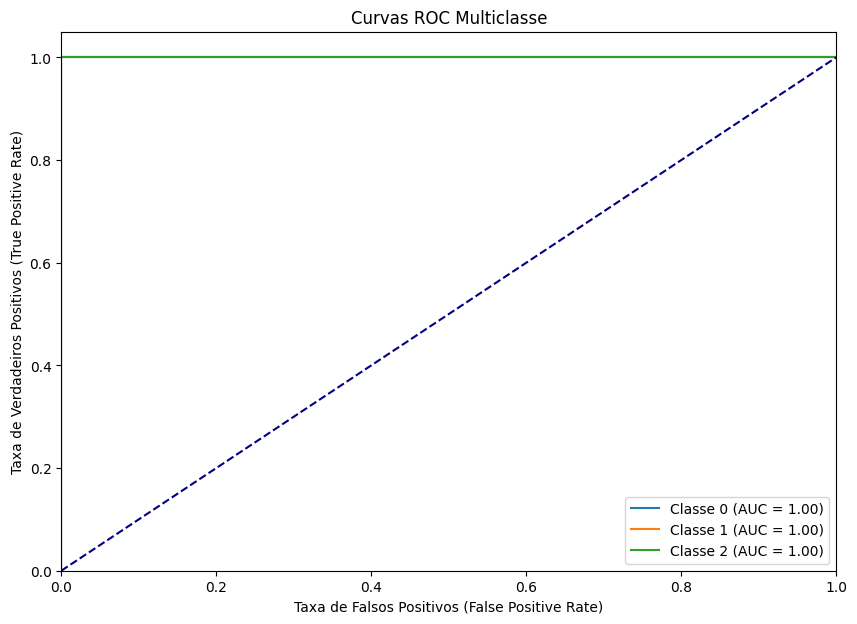

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarizar as classes para multiclasse
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Prever as probabilidades
y_pred_proba = model_pipeline.predict_proba(X_test)

# Criar um dicionário para armazenar as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular a curva ROC para cada classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar todas as curvas ROC
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

# Plotar a linha de sorte (classificação aleatória)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curvas ROC Multiclasse')
plt.legend(loc="lower right")
plt.show()


In [ ]:
def make_prediction(filename):
    # Carregar o modelo salvo (Gradient Boosting no lugar de Random Forest)
    model_pipeline = joblib.load("gradient_boosting_model.pkl")

    # Carregar o LabelEncoder salvo
    label_encoder = joblib.load("label_encoder.pkl")

    # Carregar os dados para previsão
    df = pd.read_csv(filename)

    # Excluir a primeira coluna se necessário
    X_new = df.iloc[:, 1:]  # Ajustar conforme necessário

    # Fazer a previsão
    y_pred = model_pipeline.predict(X_new)

    # Decodificar os rótulos (converter números de volta para as classes originais)
    predictions = label_encoder.inverse_transform(y_pred)

    # Exibir as previsões
    print(predictions)

if __name__ == "__main__":
    make_prediction("/content/Paper-SENSORS/Annex A - Dataset with 50 chosen features.csv")



['ransomware de encriptador' 'goodware' 'ransomware de encriptador' ...
 'goodware' 'ransomware de encriptador' 'ransomware de encriptador']


In [ ]:
# Definir os nomes das colunas que foram usadas no treinamento do modelo
feature_columns = [
    "proc_pid", "file", "urls", "type", "name", "ext_urls",
    "path", "program", "info", "positives", "families",
    "description", "sign_name", "sign_stacktrace", "arguments",
    "api", "category", "imported_dll_count", "dll", "pe_res_name",
    "filetype", "pe_sec_name", "entropy", "hosts", "requests",
    "mitm", "domains", "dns_servers", "tcp", "udp",
    "dead_hosts", "proc", "beh_command_line", "process_path",
    "tree_command_line", "children", "tree_process_name",
    "command_line", "regkey_read", "directory_enumerated",
    "regkey_opened", "file_created", "wmi_query", "dll_loaded",
    "regkey_written", "file_read", "apistats", "errors", "action", "log"
]

# Definir a linha de exemplo (sem a coluna 'family')
example_data = [
   1,1,0,0,0,0,0,0,0,1,0,3,3,0,1,1,1,1,6,2,2,4,4,14,14,0,13,2,26,22,0,2,2,2,2,0,2,0,0,0,0,0,0,0,0,0,8,0,1,17
]

# Criar um DataFrame a partir da linha de exemplo
new_df = pd.DataFrame([example_data], columns=feature_columns)

# Fazer a previsão
y_pred = model_pipeline.predict(new_df)

# Decodificar a previsão
predicted_class = label_encoder.inverse_transform(y_pred)

# Exibir a classe prevista
print(f"Predicted class: {predicted_class[0]}")

Predicted class: ransomware de encriptador


In [ ]:
# L,0,0,0,0,0,0,0,0,0,1,0,3,3,0,0,0,0,1,13,4,4,5,5,3,4,0,3,1,1,15,0,2,2,2,2,0,2,0,0,0,0,0,0,1,0,0,11,0,1,18

# Definir a linha de exemplo (sem a coluna 'family')
example_data = [
   0,0,0,0,0,0,0,0,0,1,0,3,3,0,0,0,0,1,13,4,4,5,5,3,4,0,3,1,1,15,0,2,2,2,2,0,2,0,0,0,0,0,0,1,0,0,11,0,1,18
]

# Criar um DataFrame a partir da linha de exemplo
new_df = pd.DataFrame([example_data], columns=feature_columns)

# Fazer a previsão
y_pred = model_pipeline.predict(new_df)

# Decodificar a previsão se necessário
predicted_class = label_encoder.inverse_transform(y_pred)

print(f"Predicted class: {predicted_class[0]}")

Predicted class: ransomware de locker


In [ ]:
# G,0,0,0,0,0,0,0,0,0,1,0,7,7,0,3,3,3,1,9,11,11,5,5,7,8,0,7,1,6,27,0,2,2,2,2,0,2,0,9,0,26,0,0,13,0,0,37,0,1,18

# Definir a linha de exemplo (sem a coluna 'family')
example_data = [
   0,0,0,0,0,0,0,0,0,1,0,7,7,0,3,3,3,1,9,11,11,5,5,7,8,0,7,1,6,27,0,2,2,2,2,0,2,0,9,0,26,0,0,13,0,0,37,0,1,18
]

# Criar um DataFrame a partir da linha de exemplo
new_df = pd.DataFrame([example_data], columns=feature_columns)

# Fazer a previsão
y_pred = model_pipeline.predict(new_df)

# Decodificar a previsão se necessário
predicted_class = label_encoder.inverse_transform(y_pred)

print(f"Predicted class: {predicted_class[0]}")

Predicted class: goodware


In [ ]:
# E,0,0,0,0,0,0,0,0,0,1,0,15,15,0,45,45,45,1,1,0,0,3,3,21,19,0,18,2,32,28,0,2,2,2,2,0,2,0,7,45,2,37,0,9,0,322,54,0,1,377

# Definir a linha de exemplo (sem a coluna 'family')
example_data = [
   0,0,0,0,0,0,0,0,0,1,0,15,15,0,45,45,45,1,1,0,0,3,3,21,19,0,18,2,32,28,0,2,2,2,2,0,2,0,7,45,2,37,0,9,0,322,54,0,1,377
]

# Criar um DataFrame a partir da linha de exemplo
new_df = pd.DataFrame([example_data], columns=feature_columns)

# Fazer a previsão
y_pred = model_pipeline.predict(new_df)

# Decodificar a previsão se necessário
predicted_class = label_encoder.inverse_transform(y_pred)

print(f"Predicted class: {predicted_class[0]}")

Predicted class: ransomware de encriptador


In [ ]:
# G,0,0,0,0,0,0,0,0,0,1,0,7,7,0,3,3,3,1,9,11,11,5,5,7,8,0,7,1,6,27,0,2,2,2,2,0,2,0,9,0,26,0,0,13,0,0,37,0,1,18
# E,0,0,0,0,0,0,0,0,0,1,0,15,15,0,45,45,45,1,1,0,0,3,3,21,19,0,18,2,32,28,0,2,2,2,2,0,2,0,7,45,2,37,0,9,0,322,54,0,1,377
# L,0,0,0,0,0,0,0,0,0,1,0,6,6,0,53,53,53,1,14,9,9,5,5,1,0,0,0,0,0,0,0,2,2,2,2,0,2,0,0,0,0,0,0,2,0,1,18,0,1,29
# Definir os dados de exemplo (sem a coluna 'family')
example_data = [
    [0,0,0,0,0,0,0,0,0,1,0,7,7,0,3,3,3,1,9,11,11,5,5,7,8,0,7,1,6,27,0,2,2,2,2,0,2,0,9,0,26,0,0,13,0,0,37,0,1,18],
    [0,0,0,0,0,0,0,0,0,1,0,15,15,0,45,45,45,1,1,0,0,3,3,21,19,0,18,2,32,28,0,2,2,2,2,0,2,0,7,45,2,37,0,9,0,322,54,0,1,377],
    [0,0,0,0,0,0,0,0,0,1,0,6,6,0,53,53,53,1,14,9,9,5,5,1,0,0,0,0,0,0,0,2,2,2,2,0,2,0,0,0,0,0,0,2,0,1,18,0,1,29]
]

# Criar um DataFrame a partir da linha de exemplo
new_df = pd.DataFrame(example_data, columns=feature_columns)

# Fazer a previsão
y_pred = model_pipeline.predict(new_df)

# Decodificar a previsão se necessário
predicted_class = label_encoder.inverse_transform(y_pred)

# Exibir a classe prevista para as duas linhas
for i, prediction in enumerate(predicted_class):
    print(f"Predicted class for example {i+1}: {prediction}")

Predicted class for example 1: goodware
Predicted class for example 2: ransomware de encriptador
Predicted class for example 3: ransomware de locker
